## Assignment

When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery, you must predict the total delivery duration in seconds, i.e., the time taken from:

- **Start**: The time the consumer submits the order (`created_at`)
- **End**: When the order is delivered to the consumer (`actual_delivery_time`)


## Data Description

The attached file `historical_data.csv` contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. We have added noise to the dataset to obfuscate certain business details. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds.

The target value to predict here is the total seconds value between `created_at` and `actual_delivery_time`.

### Columns in historical_data.csv

#### Time Features

- **`market_id`**: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id.
- **`created_at`**: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific.)
- **`actual_delivery_time`**: Timestamp in UTC when the order was delivered to the consumer.

#### Store Features

- **`store_id`**: An id representing the restaurant the order was submitted for.
- **`store_primary_category`**: Cuisine category of the restaurant, e.g., Italian, Asian.
- **`order_protocol`**: A store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol.

#### Order Features

- **`total_items`**: Total number of items in the order.
- **`subtotal`**: Total value of the order submitted (in cents).
- **`num_distinct_items`**: Number of distinct items included in the order.
- **`min_item_price`**: Price of the item with the least cost in the order (in cents).
- **`max_item_price`**: Price of the item with the highest cost in the order (in cents).

#### Market Features

DoorDash being a marketplace, we have information on the state of the marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of `created_at` (order submission time):

- **`total_onshift_dashers`**: Number of available dashers who are within 10 miles of the store at the time of order creation.
- **`total_busy_dashers`**: Subset of above `total_onshift_dashers` who are currently working on an order.
- **`total_outstanding_orders`**: Number of orders within 10 miles of this order that are currently being processed.

### Predictions from Other Models

We have predictions from other models for various stages of the delivery process that we can use:

- **`estimated_order_place_duration`**: Estimated time for the restaurant to receive the order from DoorDash (in seconds).
- **`estimated_store_to_consumer_driving_duration`**: Estimated travel time between store and consumer (in seconds).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [2]:
#read_data
delivery_data=pd.read_csv("/Users/suchit/Desktop/Random/Dataset/doordash_historical_data.csv")
delivery_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [3]:
delivery_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [4]:
delivery_data["created_at"]=pd.to_datetime(delivery_data["created_at"])
delivery_data["actual_delivery_time"]=pd.to_datetime(delivery_data["actual_delivery_time"])                             

In [5]:
#creating target variable which is actual total delivery duration
from datetime import datetime
delivery_data["actual_total_delivery_duration"]= delivery_data["actual_delivery_time"]- delivery_data["created_at"]

In [6]:
#busy dasher ration feature added
delivery_data["busy_dasher_ratio"]=delivery_data["total_busy_dashers"]/delivery_data["total_onshift_dashers"]

In [7]:
#non prepatartion duration feature added
delivery_data["non_preperation_duration"]= delivery_data["estimated_order_place_duration"] + delivery_data["estimated_store_to_consumer_driving_duration"]

In [8]:
delivery_data["market_id"].value_counts()

2.0    55058
4.0    47599
1.0    38037
3.0    23297
5.0    18000
6.0    14450
Name: market_id, dtype: int64

In [9]:
delivery_data["order_protocol"].nunique()

7

In [10]:
delivery_data["store_id"].nunique()

6743

In [11]:
one_hot_encoder=OneHotEncoder(sparse=False)

# Encode the "market_id" column

encoded_market_id = one_hot_encoder.fit_transform(delivery_data[["market_id"]])
encoded_market_id_columns = one_hot_encoder.get_feature_names_out(["market_id"])

# Create a DataFrame with the encoded values
encoded_market_id_dataframe = pd.DataFrame(encoded_market_id, columns=encoded_market_id_columns)
encoded_market_id_dataframe

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,market_id_nan
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
197423,1.0,0.0,0.0,0.0,0.0,0.0,0.0
197424,1.0,0.0,0.0,0.0,0.0,0.0,0.0
197425,1.0,0.0,0.0,0.0,0.0,0.0,0.0
197426,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Encode the "order_protocol" column

encoded_order_protocol=one_hot_encoder.fit_transform(delivery_data[["order_protocol"]])
encoded_order_protocol_columns=one_hot_encoder.get_feature_names_out(["order_protocol"])
encoded_order_protocol_dataframe= pd.DataFrame(encoded_order_protocol, columns= encoded_order_protocol_columns)
encoded_order_protocol_dataframe

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,order_protocol_nan
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
197423,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
197424,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
197425,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
197426,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
delivery_data["store_primary_category"].isnull().sum()

4760

In [14]:
#create a dictionary with most repeated categories of each store to fill null row where possible
store_id_unique=delivery_data["store_id"].unique().tolist()
store_id_and_category={store_id:delivery_data[delivery_data.store_id == store_id].store_primary_category.mode()
                      for store_id in store_id_unique}

In [15]:
def fill(store_id):
    """Return primary store category from store_id_and_category dictionary"""
    
    try:
    	return store_id_and_category[store_id].values[0]
    except:
        return np.nan

# Fill NaN values in the "store_primary_category" column
delivery_data["category"] = delivery_data.store_id.apply(fill)

In [16]:
# Encode the "nan_free_store_primary_category" column
encoded_store_primary_category = one_hot_encoder.fit_transform(delivery_data[["category"]])
encoded_store_primary_category_columns = one_hot_encoder.get_feature_names_out(["category"])

# Create a DataFrame with the encoded values
encoded_store_primary_category_df = pd.DataFrame(encoded_store_primary_category, columns=encoded_store_primary_category_columns)
encoded_store_primary_category_df

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese,category_nan
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
delivery_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dasher_ratio,non_preperation_duration,category
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,0 days 01:02:59,0.424242,1307.0,american
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,0 days 01:07:04,2.000000,1136.0,indian
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,0 days 00:29:41,0.000000,1136.0,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,0 days 00:51:15,1.000000,735.0,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,0 days 00:39:50,1.000000,1096.0,indian


In [18]:
train_df=delivery_data.drop(columns=["market_id", "created_at", "actual_delivery_time", "store_id", "store_primary_category", "order_protocol", "category"])
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dasher_ratio,non_preperation_duration
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,0 days 01:02:59,0.424242,1307.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,0 days 01:07:04,2.000000,1136.0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,0 days 00:29:41,0.000000,1136.0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,0 days 00:51:15,1.000000,735.0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,0 days 00:39:50,1.000000,1096.0


In [19]:
train_df=pd.concat([train_df, encoded_market_id_dataframe, encoded_order_protocol_dataframe, encoded_store_primary_category_df], axis=1 )
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese,category_nan
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
train_df.drop(columns=["category_nan", "order_protocol_nan", "market_id_nan"], axis=1, inplace=True)

In [21]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902,...,0.028545,0.013689,0.073725,0.105701,0.027184,0.189384,0.034260,0.037834,0.064935,0.173122
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
train_df["busy_dasher_ratio"].describe()

count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dasher_ratio, dtype: float64

In [23]:
#check inf values with nan to drop all nans
np.where(np.any(~np.isfinite(train_df),axis=0) == True)

(array([ 5,  6,  7,  9, 10, 11, 12]),)

In [24]:
#replace inf values with nan to drop all nan
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

#drop all nans
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
train_df.shape

(177070, 100)

In [26]:
#it could take some time to run this cell since we are calculation correlation matrix in dimensions of 100*100
#to have better visualization we will take only one triangle
#because other triangle is only its symmetry(i.e a * b and b * a)

#Generate a mask for upper triangle
corr = train_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))

<AxesSubplot:>

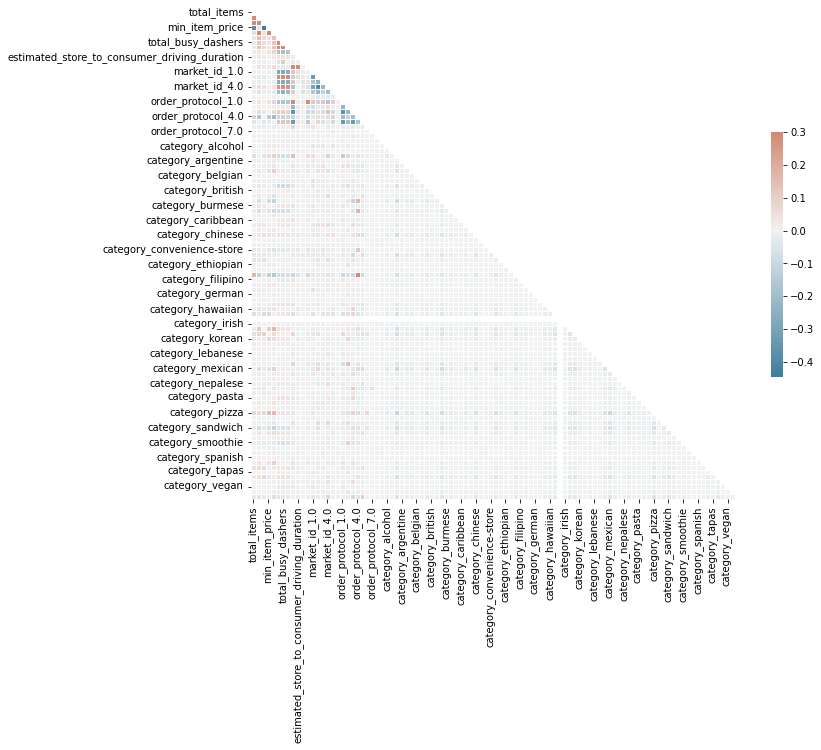

In [27]:
#setup a matplotlib figure
f, ax = plt.subplots(figsize=(11,9))
#Generate a custom diverging colormap
cmap = sns.diverging_palette(230,20, as_cmap= True)
#Draw a heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3,
           center=0, square=True, linewidths=.5, cbar_kws={"shrink":.5})

In [28]:
train_df["category_indonesian"].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

In [29]:
train_df.drop(columns="category_indonesian", axis=1, inplace=True)

In [30]:
#it could take some time to run this cell since we are calculation correlation matrix in dimensions of 100*100
#to have better visualization we will take only one triangle
#because other triangle is only its symmetry(i.e a * b and b * a)

#Generate a mask for upper triangle
corr = train_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))

<AxesSubplot:>

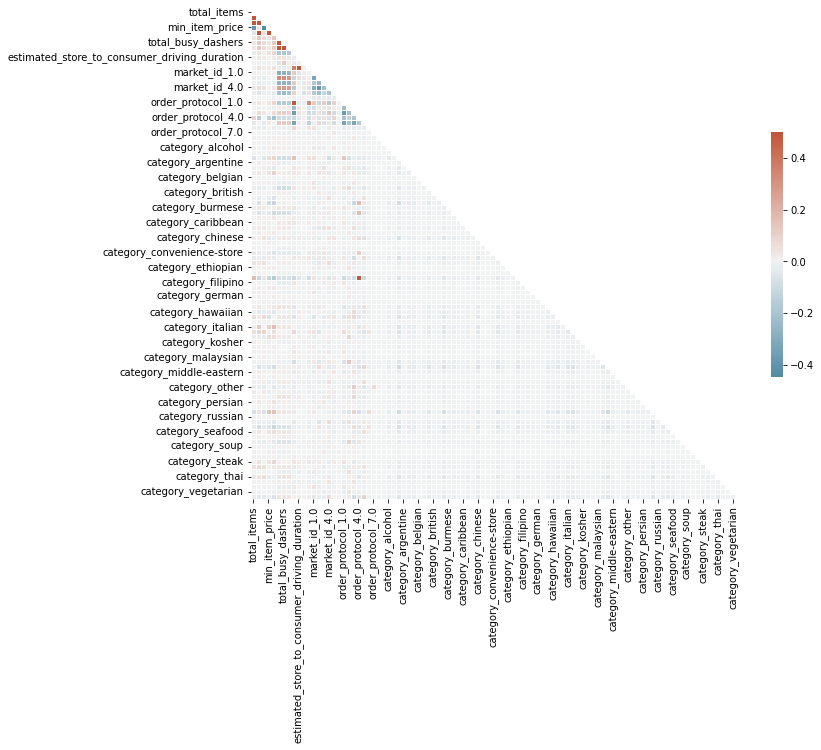

In [31]:
#setup a matplotlib figure
f, ax = plt.subplots(figsize=(11,9))
#Generate a custom diverging colormap
cmap = sns.diverging_palette(230,20, as_cmap= True)
#Draw a heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.5,
           center=0, square=True, linewidths=.8, cbar_kws={"shrink":.5})

In [32]:
def get_top_abs_correlations(df, n=5):
    """Sort correlations in the decending order and return n highest result"""
    au_corr = df.corr().abs()

    # Exclude diagonal and upper triangular part
    mask = np.triu(np.ones(au_corr.shape), k=1).astype(bool)
    au_corr = au_corr.where(mask)

    # Stack the DataFrame and sort by correlation in descending order
    au_corr = au_corr.stack().sort_values(ascending=False)

    return au_corr[:n]

In [33]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers          0.941741
                                              total_outstanding_orders    0.934639
total_busy_dashers                            total_outstanding_orders    0.931295
estimated_store_to_consumer_driving_duration  non_preperation_duration    0.923086
estimated_order_place_duration                order_protocol_1.0          0.897645
total_items                                   num_distinct_items          0.758146
subtotal                                      num_distinct_items          0.682890
total_items                                   subtotal                    0.557175
min_item_price                                max_item_price              0.541241
subtotal                                      max_item_price              0.507947
order_protocol_4.0                            category_fast               0.489946
num_distinct_items                            min_item_price 

In [34]:
train_df=delivery_data.drop(columns=["market_id", "created_at", "actual_delivery_time", "store_id", "store_primary_category", "order_protocol", "category"])

In [35]:
train_df=pd.concat([train_df, encoded_order_protocol_dataframe, encoded_store_primary_category_df], axis=1 )

train_df.drop(columns=["category_nan", "order_protocol_nan", "total_onshift_dashers", "total_busy_dashers", "non_preperation_duration", "category_indonesian"], axis=1, inplace=True)

#replace inf values with nan to drop all nan
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

#drop all nans
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dasher_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4,3441,4,557,1239,21.0,446,861.0,0 days 01:02:59,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1900,1,1400,1400,2.0,446,690.0,0 days 01:07:04,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1900,1,1900,1900,0.0,446,690.0,0 days 00:29:41,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,6900,5,600,1800,2.0,446,289.0,0 days 00:51:15,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,3900,3,1100,1600,9.0,446,650.0,0 days 00:39:50,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

In [37]:
train_df=delivery_data.drop(columns=["market_id", "created_at", "actual_delivery_time", "store_id", "store_primary_category", "order_protocol", "category"])
train_df=pd.concat([train_df, encoded_store_primary_category_df], axis=1 )

train_df.drop(columns=["category_nan", "total_onshift_dashers", "total_busy_dashers", "non_preperation_duration", "category_indonesian"], axis=1, inplace=True)

#replace inf values with nan to drop all nan
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

#drop all nans
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dasher_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4,3441,4,557,1239,21.0,446,861.0,0 days 01:02:59,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1900,1,1400,1400,2.0,446,690.0,0 days 01:07:04,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1900,1,1900,1900,0.0,446,690.0,0 days 00:29:41,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,6900,5,600,1800,2.0,446,289.0,0 days 00:51:15,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,3900,3,1100,1600,9.0,446,650.0,0 days 00:39:50,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                     num_distinct_items                0.758146
subtotal                        num_distinct_items                0.682890
total_items                     subtotal                          0.557175
min_item_price                  max_item_price                    0.541241
subtotal                        max_item_price                    0.507947
num_distinct_items              min_item_price                    0.446733
total_items                     min_item_price                    0.389277
total_outstanding_orders        estimated_order_place_duration    0.171049
total_items                     category_fast                     0.170988
max_item_price                  category_italian                  0.169775
                                category_fast                     0.166169
                                category_pizza                    0.157577
estimated_order_place_duration  category_american                 0.150174

In [39]:
train_df=delivery_data.drop(columns=["market_id", "created_at", "actual_delivery_time", "store_id", "store_primary_category", "order_protocol", "category"])
train_df=pd.concat([train_df, encoded_store_primary_category_df], axis=1 )

train_df.drop(columns=["category_nan", "total_onshift_dashers", "total_busy_dashers", "non_preperation_duration", "category_indonesian"], axis=1, inplace=True)

#replace inf values with nan to drop all nan
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

#drop all nans
train_df.dropna(inplace=True)


train_df["percent_distinct_item_of_total"]=train_df["num_distinct_items"]/train_df["total_items"]
train_df["avg_price_per_item"]= train_df["subtotal"]/train_df["total_items"]
train_df['price_range'] = train_df['max_item_price'] - train_df['min_item_price']
train_df.drop(columns=["num_distinct_items", "subtotal", "max_item_price", "min_item_price"], inplace=True)

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                     percent_distinct_item_of_total    0.445751
                                price_range                       0.333304
                                avg_price_per_item                0.310759
percent_distinct_item_of_total  avg_price_per_item                0.226711
category_pizza                  avg_price_per_item                0.225510
category_fast                   avg_price_per_item                0.175950
total_outstanding_orders        estimated_order_place_duration    0.171049
total_items                     category_fast                     0.170988
category_italian                avg_price_per_item                0.158193
category_fast                   percent_distinct_item_of_total    0.153614
estimated_order_place_duration  category_american                 0.150174
category_american               category_pizza                    0.106998
estimated_order_place_duration  category_fast                     0.106739

In [40]:
train_df

train_df['actual_total_delivery_duration'] = train_df['actual_total_delivery_duration'].dt.total_seconds()

# Now you can safely convert the DataFrame to float64
train_df = train_df.astype('float64')


In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [42]:
def compute_vif(features):
    """Compute VIF score using variance_inflation_factor() function"""
    vif_data=pd.DataFrame()
    vif_data["feature"]=features
    vif_data["VIF"]= [variance_inflation_factor(train_df[features].values,i) for i in range(len(features))]
    return vif_data.sort_values(by=["VIF"]).reset_index(drop=True)

In [43]:
#apply VIF computataion to all features to check multiple colinearity
features=train_df.drop(columns="actual_total_delivery_duration").columns.to_list()
vif_data= compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000369
1,category_chocolate,1.000488
2,category_belgian,1.000749
3,category_russian,1.003225
4,category_african,1.003820
...,...,...
76,busy_dasher_ratio,6.369592
77,category_american,7.033601
78,estimated_store_to_consumer_driving_duration,7.210812
79,estimated_order_place_duration,13.472106


In [44]:
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("I will remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif (features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True
selected_features = vif_data['feature'].values.tolist()
vif_data

I will remove percent_distinct_item_of_total


,feature,VIF
0,category_alcohol-plus-food,1.000221
1,category_chocolate,1.000361
2,category_belgian,1.000451
3,category_russian,1.002016
4,category_gluten-free,1.002363
...,...,...
75,category_american,4.505927
76,avg_price_per_item,5.958952
77,busy_dasher_ratio,6.357882
78,estimated_store_to_consumer_driving_duration,7.192612


In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#selected features are selected in multicollinearity check part
X = train_df[selected_features]
y= train_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

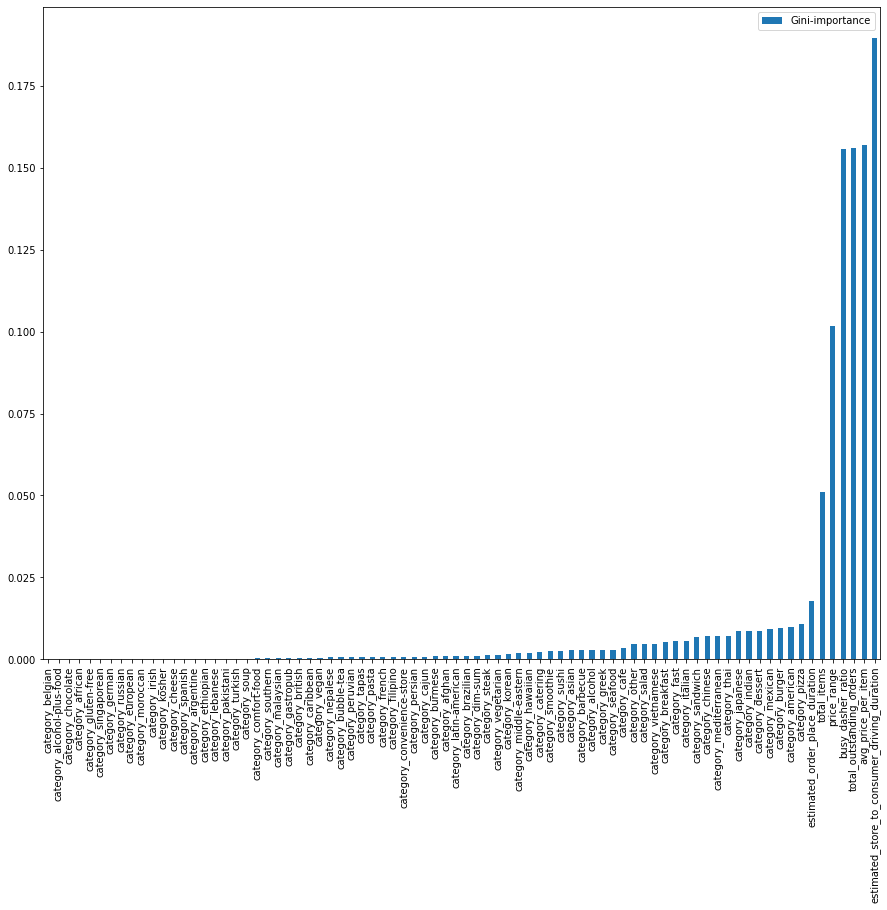

In [46]:
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42) 
forest. fit(X_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance j
for feature, importance in zip(X.columns, forest.feature_importances_):
	feats[feature] = importance #add the name/value pair |
importances = pd.DataFrame.from_dict (feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind="bar", rot=90, figsize=(15,12))
plt.show()

In [47]:
importances.sort_values(by="Gini-importance")[-35:].index.to_list()

['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_alcohol',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_fast',
 'category_italian',
 'category_sandwich',
 'category_chinese',
 'category_mediterranean',
 'category_thai',
 'category_japanese',
 'category_indian',
 'category_dessert',
 'category_mexican',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range',
 'busy_dasher_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

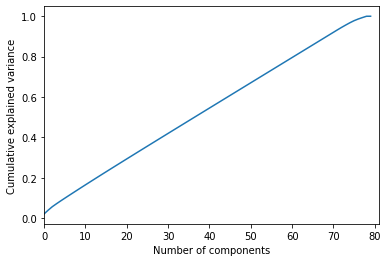

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 

X_Train=X_train.values 
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train 
X_std=StandardScaler( ).fit_transform(X_Train)
pca = PCA().fit(X_std) 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [49]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [50]:
def scale(scaler, X, y):
    """Apply the selected scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    return X_scaled, y_scaled, X_scaler, y_scaler

In [51]:
# example to show how to use it
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y) 

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42) 


In [52]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    """Convert the scaled error to actual error"""
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    # return RMSE with squared False

    rmse_error = mean_squared_error(y_test, y_predict, squared=False)
    print("Error = "'{}'.format(rmse_error)+" in " + model_name)
    print()
    return rmse_error, y_predict

In [53]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor



In [54]:
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """Apply selected regression model to data and measure error"""
    model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    y_test_predict = model.predict(X_test)
    test_error = mean_squared_error(y_test, y_test_predict, squared=False)
    if verbose:
        print("Train error = {} in {}".format(train_error, model_name))
        print("Test error = {} in {}".format(test_error, model_name))
    trained_model = model
    return trained_model, y_test_predict, train_error, test_error

In [55]:
pred_dict ={
    "regression_model":[],
    "feature_set": [],
    "scalar_name": [],
    "RMSE": []
}

regression_models={
    "RidgeRegression" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost" :XGBRegressor(),
    "LGBM" : LGBMRegressor(),
    "MLP" : MLPRegressor(),
}

feature_sets={
    "full_dataset" : X.columns.to_list(),
    "selected_features_40" : importances.sort_values(by="Gini-importance")[-40:].index.to_list(),
    "selected_features_20" : importances.sort_values(by="Gini-importance")[-20:].index.to_list(),
    "selected_features_10" : importances.sort_values(by="Gini-importance")[-10:].index.to_list()
}

scalars={
    "Standard_Scalar" : StandardScaler(),
    "MinMaxScalar" : MinMaxScaler(),
    "NotScale" : None
}

#examine the error for each combination
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scalar_name in scalars.keys():
        print(f"------scaled with {scalar_name}---------included columns are {feature_set_name}")
        print("")
        for regression_model_name in regression_models.keys():
            if scalar_name == "NotScale":
                X=train_df[feature_set]
                y=train_df["actual_total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[regression_model_name], regression_model_name, verbose=True)


            else:
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalars[scalar_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:, 0], X_test_scaled, y_test_scaled, regression_models[regression_model_name], regression_model_name, verbose=True)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, regression_model_name)

            pred_dict["regression_model"].append(regression_model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scalar_name"].append(scalar_name)
            pred_dict["RMSE"].append(rmse_error)

------scaled with Standard_Scalar---------included columns are full_dataset

Train error = 0.7679632280812583 in RidgeRegression
Test error = 1.4719302095531308 in RidgeRegression
Error = 2053.6985497900873 in RidgeRegression

Train error = 0.7653021374840772 in DecisionTree
Test error = 1.4744739396998416 in DecisionTree
Error = 2057.2476684096064 in DecisionTree

Train error = 0.28544465503940875 in RandomForest
Test error = 1.4689615190993195 in RandomForest
Error = 2049.55650878828 in RandomForest

Train error = 0.6958678846782153 in XGBoost
Test error = 1.4590923678031187 in XGBoost
Error = 2035.786657077656 in XGBoost

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 70
[LightGBM] [I

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1058.795101129403 in MLP
Test error = 2050.430411233579 in MLP
------scaled with Standard_Scalar---------included columns are selected_features_40

Train error = 0.7685800171882018 in RidgeRegression
Test error = 1.472149277761882 in RidgeRegression
Error = 2054.004202911205 in RidgeRegression

Train error = 0.7653050291234431 in DecisionTree
Test error = 1.4739589994313642 in DecisionTree
Error = 2056.529202224364 in DecisionTree

Train error = 0.2856312278464954 in RandomForest
Test error = 1.467948861985928 in RandomForest
Error = 2048.143607258229 in RandomForest

Train error = 0.6877603250804641 in XGBoost
Test error = 1.4593123829271362 in XGBoost
Error = 2036.0936306598262 in XGBoost

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1447
[LightGBM] [Info] Number 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1057.128450887334 in MLP
Test error = 2047.7547023427255 in MLP
------scaled with Standard_Scalar---------included columns are selected_features_20

Train error = 0.7701221891430123 in RidgeRegression
Test error = 1.4731250237727922 in RidgeRegression
Error = 2055.365604528323 in RidgeRegression

Train error = 0.7662722643089452 in DecisionTree
Test error = 1.472583688672633 in DecisionTree
Error = 2054.610311170708 in DecisionTree

Train error = 0.2859397482704904 in RandomForest
Test error = 1.4688633027392213 in RandomForest
Error = 2049.419473217578 in RandomForest

Train error = 0.6912574260819417 in XGBoost
Test error = 1.4599409230315548 in XGBoost
Error = 2036.9705961389795 in XGBoost

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1387
[LightGBM] [Info] Numbe

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1056.5761821288158 in MLP
Test error = 2048.429255820423 in MLP
------scaled with Standard_Scalar---------included columns are selected_features_10

Train error = 0.771714207836751 in RidgeRegression
Test error = 1.4739870636477654 in RidgeRegression
Error = 2056.5683585920706 in RidgeRegression

Train error = 0.7663420088976927 in DecisionTree
Test error = 1.47257427451221 in DecisionTree
Error = 2054.597176140608 in DecisionTree

Train error = 0.28768239517969585 in RandomForest
Test error = 1.4698379820536944 in RandomForest
Error = 2050.779386535243 in RandomForest

Train error = 0.7034401245387647 in XGBoost
Test error = 1.4609702015944932 in XGBoost
Error = 2038.406688199901 in XGBoost

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1357
[LightGBM] [Info] Number

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [56]:
pred_df=pd.DataFrame(pred_dict)

In [57]:
pred_df

,regression_model,feature_set,scalar_name,RMSE
0,RidgeRegression,full_dataset,Standard_Scalar,2053.698550
1,DecisionTree,full_dataset,Standard_Scalar,2057.247668
2,RandomForest,full_dataset,Standard_Scalar,2049.556509
3,XGBoost,full_dataset,Standard_Scalar,2035.786657
4,LGBM,full_dataset,Standard_Scalar,2033.435581
...,...,...,...,...
67,DecisionTree,selected_features_10,NotScale,2162.596190
68,RandomForest,selected_features_10,NotScale,2162.596190
69,XGBoost,selected_features_10,NotScale,2162.596190
70,LGBM,selected_features_10,NotScale,2162.596190


<AxesSubplot:>

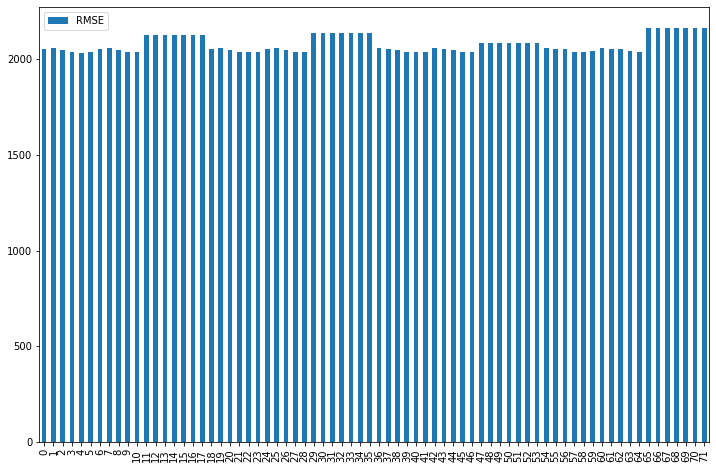

In [58]:
pred_df.plot(kind='bar', figsize=(12,8))

In [59]:
train_df["prep_time"]=train_df["actual_total_delivery_duration"]-train_df["estimated_store_to_consumer_driving_duration"] - train_df["estimated_order_place_duration"]

In [60]:

feature_sets={
    "selected_features_40" : importances.sort_values(by="Gini-importance")[-40:].index.to_list()   
}

scalars={
    "Standard_Scalar" : StandardScaler()
}

In [61]:
#examine the error for each combination
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scalar_name in scalars.keys():
        print(f"------scaled with {scalar_name}---------included columns are {feature_set_name}")
        print("")
        for regression_model_name in regression_models.keys():
                X = train_df[feature_set]
                y =train_df["prep_time"]

                #to get indices
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                train_indices=X_train.index
                test_indices = X_test.index


                #scale
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalars[scalar_name], X[feature_set], y)

                #apply indexing
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:, 0], X_test_scaled, y_test_scaled, regression_models[regression_model_name], regression_model_name, verbose=True)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, regression_model_name)

                pred_dict["regression_model"].append(regression_model_name)
                pred_dict["feature_set"].append(feature_set_name)
                pred_dict["scalar_name"].append(scalar_name)
                pred_dict["RMSE"].append(rmse_error)

------scaled with Standard_Scalar---------included columns are selected_features_40

Train error = 0.7849600477919383 in RidgeRegression
Test error = 1.5035238167554659 in RidgeRegression
Error = 2054.004191346425 in RidgeRegression

Train error = 0.7693331411018538 in DecisionTree
Test error = 1.4976355414184739 in DecisionTree
Error = 2045.9600605603337 in DecisionTree

Train error = 0.2904594981228305 in RandomForest
Test error = 1.4966826760025238 in RandomForest
Error = 2044.658325571943 in RandomForest

Train error = 0.7030694130984669 in XGBoost
Test error = 1.491085153492582 in XGBoost
Error = 2037.0113998031932 in XGBoost

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1447
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 40
[Light

In [62]:
feature_sets={
    "selected_features_40" : importances.sort_values(by="Gini-importance")[-40:].index.to_list()   
}

scalars={
    "Standard_Scalar" : StandardScaler()
}

regression_models={
    "LGBM" : LGBMRegressor()
}

#examine the error for each combination
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scalar_name in scalars.keys():
        print(f"------scaled with {scalar_name}---------included columns are {feature_set_name}")
        print("")
        for regression_model_name in regression_models.keys():
                X = train_df[feature_set]
                y = train_df["prep_time"]

                #to get indices
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                train_indices=X_train.index
                test_indices = X_test.index


                #scale
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalars[scalar_name], X, y)

                #apply indexing
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:, 0], X_test_scaled, y_test_scaled, regression_models[regression_model_name], regression_model_name, verbose=True)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, regression_model_name)

                pred_dict["regression_model"].append(regression_model_name)
                pred_dict["feature_set"].append(feature_set_name)
                pred_dict["scalar_name"].append(scalar_name)
                pred_dict["RMSE"].append(rmse_error)

------scaled with Standard_Scalar---------included columns are selected_features_40

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1447
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 40
[LightGBM] [Info] Start training from score -0.002301
Train error = 0.7452582832921593 in LGBM
Test error = 1.4885753017487364 in LGBM
Error = 2033.5826242677697 in LGBM



In [63]:
#choose best perform model and extract the prediction for preparation duration
pred_values_dict = {
    "actual_total_delivery_duration" :train_df["actual_total_delivery_duration"][test_indices].values.tolist(),
    "prep_duration_prediction" : y_predict[:,0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration" : train_df["estimated_order_place_duration"][test_indices].values.tolist()
}

In [64]:
values_df=pd.DataFrame.from_dict(pred_values_dict)
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1718.073033,380.0,251.0
1,1839.0,1573.661500,747.0,446.0
2,1927.0,2049.556749,543.0,251.0
3,2657.0,1294.531543,445.0,251.0
4,3596.0,1977.600699,691.0,446.0
...,...,...,...,...
35409,9557.0,2756.293948,768.0,446.0
35410,1864.0,2107.270008,324.0,446.0
35411,2674.0,1885.087235,791.0,251.0
35412,2234.0,1928.748680,687.0,251.0


In [65]:
values_df["sum_total_delivery_duration"]= values_df["prep_duration_prediction"] + values_df["estimated_store_to_consumer_driving_duration"]
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1718.073033,380.0,251.0,2098.073033
1,1839.0,1573.661500,747.0,446.0,2320.661500
2,1927.0,2049.556749,543.0,251.0,2592.556749
3,2657.0,1294.531543,445.0,251.0,1739.531543
4,3596.0,1977.600699,691.0,446.0,2668.600699
...,...,...,...,...,...
35409,9557.0,2756.293948,768.0,446.0,3524.293948
35410,1864.0,2107.270008,324.0,446.0,2431.270008
35411,2674.0,1885.087235,791.0,251.0,2676.087235
35412,2234.0,1928.748680,687.0,251.0,2615.748680


In [66]:
mean_squared_error(values_df["actual_total_delivery_duration"], values_df["sum_total_delivery_duration"], squared=False)

2060.6695445437404

In [67]:
# What if we use another regression to obtain the actual total delivery durations
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration"]]
y = values_df["actual_total_delivery_duration"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
regression_models = {
    "RidgeRegression": linear_model.Ridge(),
    "DecisionTree": tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP": MLPRegressor(),
}

for model_name, model in regression_models.items():
    trained_model, y_predict, _, _ = make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=False)
    rmse = mean_squared_error(y_test, y_predict, squared=False)
    print("RMSE of {}: {}".format(model_name, rmse))

RMSE of RidgeRegression: 988.3264123705494
RMSE of DecisionTree: 997.5193477960178
RMSE of RandomForest: 1069.638153809088
RMSE of XGBoost: 1016.1383057569393
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 28331, number of used features: 2
[LightGBM] [Info] Start training from score 2869.174261
RMSE of LGBM: 1051.3507193898238
RMSE of MLP: 1003.9098375671006


<h5>Based on these RMSE values, we will use <b>Ridge Regression</b> or <b>MLP</b> as it has the lowest RMSE, indicating better predictive performance compared to the other models.</h5>

<h3>Or we can further choose other models and parameters</h3>